In [26]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import json

In [27]:
PATH = "data/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(PATH,sep=",",encoding="latin-1")

In [28]:
print(df.shape)
print(df.head())

(1599999, 6)
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all..

In [29]:
df = df.iloc[:,[0,-1]]
print(df.shape)
df.columns = ["opinion","content"]
print(df.head())


(1599999, 2)
   opinion                                            content
0        0  is upset that he can't update his Facebook by ...
1        0  @Kenichan I dived many times for the ball. Man...
2        0    my whole body feels itchy and like its on fire 
3        0  @nationwideclass no, it's not behaving at all....
4        0                      @Kwesidei not the whole crew 


In [30]:
df["opinion"] = df["opinion"].apply(lambda x: 1 if x == 4 else x)

In [31]:
print(df["opinion"].value_counts())

opinion
1    800000
0    799999
Name: count, dtype: int64


In [32]:
echantillon = 100_000
df = df.sample(len(df))
df = df.iloc[:echantillon]
print(df.head())
print(df.shape)
print(df["opinion"].value_counts())

         opinion                                            content
792058         0  @joemarsip actually  it's my new tweet joe (wh...
103541         0  has a head cold. Didn't have enough sense to c...
619187         0                       @therealtommyg is a LIARRRR 
706778         0  @Shontelle_Layne im upset how i haven't got an...
1075317        1  @becca4 thx  everything is great! .. minus the...
(100000, 2)
opinion
1    50103
0    49897
Name: count, dtype: int64


In [33]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df["content"])

In [34]:
tokenizer_json = tokenizer.to_json()
tokenizer_path = "tokenizer.json"
with open(tokenizer_path, 'w+', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [35]:
vocab = tokenizer.word_index
vocab_size = len(vocab)+1

In [36]:
print(vocab_size)

99030


In [37]:
from sklearn.model_selection import train_test_split

In [38]:
x_train,x_test,y_train,y_test = train_test_split(df["content"].values,df["opinion"].values,test_size=0.3)

x_train_vec = tokenizer.texts_to_sequences(x_train)
x_test_vec = tokenizer.texts_to_sequences(x_test)
print(x_train_vec[:5])

[[55696, 7528, 187, 38, 2, 3, 671, 26, 353, 5, 596, 595, 22, 77, 1391, 376], [20862, 5, 385, 4981, 8, 383, 9627], [72356, 15, 608, 57, 74, 22, 46], [46436, 51, 53, 342, 1, 68, 140, 1, 2836, 48, 320, 2, 17, 235, 16, 99, 13, 350, 1365, 615, 126, 3, 414, 9, 8, 2926, 382], [92606, 160, 52, 143, 19, 550, 172, 3126, 12, 760, 420, 9, 6, 9, 20, 13570, 420, 9]]


In [39]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_vec,padding="post")
print(train_pad.shape)
T = train_pad.shape[1]
print(train_pad[0])

(70000, 36)
[55696  7528   187    38     2     3   671    26   353     5   596   595
    22    77  1391   376     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [40]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_vec,maxlen=T,padding="post")
print(test_pad.shape)

(30000, 36)


In [41]:
from model import MySentimentClassifierModel

In [42]:
e_dim = 10
model = MySentimentClassifierModel(vocab_size,e_dim)

In [43]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [44]:
history = model.fit(train_pad,y_train,validation_data=(test_pad,y_test),epochs=2,batch_size=64)

Epoch 1/2
1094/1094 [==============================] - 148s 135ms/step - loss: 0.5707 - accuracy: 0.6925 - val_loss: 0.4686 - val_accuracy: 0.7799
Epoch 2/2
1094/1094 [==============================] - 136s 125ms/step - loss: 0.3852 - accuracy: 0.8315 - val_loss: 0.4874 - val_accuracy: 0.7646


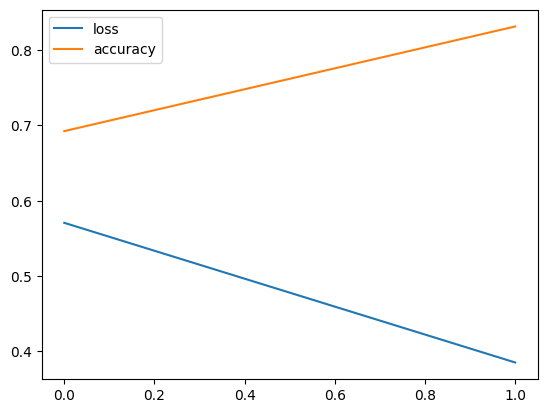

In [45]:
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["accuracy"],label = "accuracy")
plt.legend()

In [46]:
def predict_text(text):
    print(text)
    seq = tokenizer.texts_to_sequences([text])  # Envoyer le texte comme une liste pour obtenir une seule séquence
    seq_pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=T, padding="post")
    ans = model.predict(seq_pad)
    print("out:", ans)
    if ans > 0.5:
        print("C'est un sentiment positif.")
    else:
        print("C'est un sentiment négatif.")

In [47]:
predict_text("I haapy to be here")
predict_text("I hate this film")
predict_text("This is a good film")
predict_text("I love my mother ")
predict_text("I don't like the bowling")
predict_text("I like the bowling")

I haapy to be here
1/1 [==============================] - 0s 145ms/step
out: [[0.4361953]]
C'est un sentiment négatif.
I hate this film
1/1 [==============================] - 0s 10ms/step
out: [[0.25438935]]
C'est un sentiment négatif.
This is a good film
1/1 [==============================] - 0s 9ms/step
out: [[0.9079492]]
C'est un sentiment positif.
I love my mother 
1/1 [==============================] - 0s 8ms/step
out: [[0.9454098]]
C'est un sentiment positif.
I don't like the bowling
1/1 [==============================] - 0s 8ms/step
out: [[0.33672616]]
C'est un sentiment négatif.
I like the bowling
1/1 [==============================] - 0s 8ms/step
out: [[0.8067303]]
C'est un sentiment positif.


In [48]:
model.save("SC.keras")